# Подготовка к обработке данных

## Подключение и преднастройка необходимых компонент

Подключение Google Drive

In [1]:
%%time
# монтируем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 1.3 s, sys: 230 ms, total: 1.53 s
Wall time: 23.2 s


Подключение глобально необходимых библиотек

In [12]:
# для отрисовки графиков
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
import plotly.express as px

# для объединения в одну модель
from sklearn.pipeline import Pipeline

# для масштабирования
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# модули оценщика
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# для вывода результатов
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

Инициализация константы для random_state

In [3]:
# для повторяемости результатов
SEED = 100

Настройка графиков

In [4]:
# преднастройка графиков
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')

# чтобы графики были в одном окне
%matplotlib inline

Установка catboost

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.9 MB/s eta 0:00:00


## Загрузка датасета

Чтение датасета, чтобы к нему можно было обратиться методами sklearn

In [6]:
# загружаем данные с Google Drive
df = pd.read_csv('/content/drive/MyDrive/AnimeList.csv')

Проверка типов данных столбцов и того, как их интерпретировал pandas

In [7]:
# выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          24985 non-null  int64  
 1   title             24985 non-null  object 
 2   type              24927 non-null  object 
 3   score             16050 non-null  float64
 4   scored_by         24985 non-null  int64  
 5   status            24985 non-null  object 
 6   episodes          24438 non-null  float64
 7   start_date        24110 non-null  object 
 8   end_date          22215 non-null  object 
 9   source            21424 non-null  object 
 10  members           24985 non-null  int64  
 11  favorites         24985 non-null  int64  
 12  episode_duration  24387 non-null  object 
 13  total_duration    24162 non-null  object 
 14  rating            24405 non-null  object 
 15  sfw               24985 non-null  bool   
 16  approved          24985 non-null  bool  

Данный объем данных слишком велик для быстрого обучения моделей ресурсами, бесплатно предоставляемым в Google Colab.
Поэтому разумно ограничить объем выборки

In [8]:
# выбираем случайные 20000 записей со всего датасета
# также задаем random_state для повторяемости результатов
df = df.sample(n=20000, random_state=SEED)

# выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 10844 to 19496
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          20000 non-null  int64  
 1   title             20000 non-null  object 
 2   type              19949 non-null  object 
 3   score             12855 non-null  float64
 4   scored_by         20000 non-null  int64  
 5   status            20000 non-null  object 
 6   episodes          19565 non-null  float64
 7   start_date        19304 non-null  object 
 8   end_date          17784 non-null  object 
 9   source            17151 non-null  object 
 10  members           20000 non-null  int64  
 11  favorites         20000 non-null  int64  
 12  episode_duration  19533 non-null  object 
 13  total_duration    19346 non-null  object 
 14  rating            19526 non-null  object 
 15  sfw               20000 non-null  bool   
 16  approved          20000 non-null  bool   

## Анализ датасета

### Проверка статистики

Проверка на наличие отклонений важных характеристик числовых признаков: среднего арифметического, стандартного квадратичного отклонения, перцентилей, а также максимума и минимума

In [9]:
# выводим статистику числовых записей датасета
df.describe()

,anime_id,score,scored_by,episodes,members,favorites,start_year
count,20000.000000,12855.000000,2.000000e+04,19565.000000,2.000000e+04,20000.000000,16261.000000
mean,29817.209200,6.418470,1.932610e+04,15.001482,3.771719e+04,452.381400,2008.682984
std,18025.096493,0.902566,9.806842e+04,49.572439,1.621694e+05,4661.403205,13.473318
min,5.000000,1.850000,0.000000e+00,1.000000,0.000000e+00,0.000000,1917.000000
25%,10493.250000,5.790000,5.100000e+01,1.000000,2.210000e+02,0.000000,2003.000000
50%,34650.000000,6.420000,3.080000e+02,2.000000,1.085000e+03,1.000000,2013.000000
75%,45329.250000,7.070000,3.383000e+03,13.000000,9.318250e+03,18.000000,2018.000000
max,56202.000000,9.100000,2.685033e+06,3057.000000,3.779820e+06,219036.000000,2025.000000


Уточнение показателей для категориальных данных

In [10]:
# выводим статистику категориальных записей датасета
df.describe(include = [object, 'bool'])

,title,type,status,start_date,end_date,source,episode_duration,total_duration,rating,sfw,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
count,20000,19949,20000,19304,17784,17151,19533,19346,19526,20000,...,20000,20000,16397,1995,19874,20000,3767,8328,19930,20000
unique,19999,6,3,7661,7466,16,2715,4818,6,2,...,3713,242,16228,1947,19874,20000,3750,8200,19280,9797
top,Urahara,tv,finished_airing,2012-01-01,2019-01-01,original,0 days 00:24:00,0 days 04:48:00,pg_13,True,...,[],[],Furukawa Taku film.,The Minna no Uta Hakkutsu Project started in 2...,https://cdn.myanimelist.net/images/anime/1515/...,https://myanimelist.net/anime/51045/Sode_no_Quilt,https://www.youtube.com/watch?v=9GVMoxhtrY8,Spirit Guardians,おしりたんてい,[]
freq,2,6092,19402,127,69,7810,928,267,6818,18757,...,10644,16159,12,5,1,1,3,5,7,9638


Проверка статистики по "типу" аниме

In [14]:
fig = px.pie(df, 'type')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Проверка статистики показа аниме по дням недели

<Axes: xlabel='broadcast_day'>

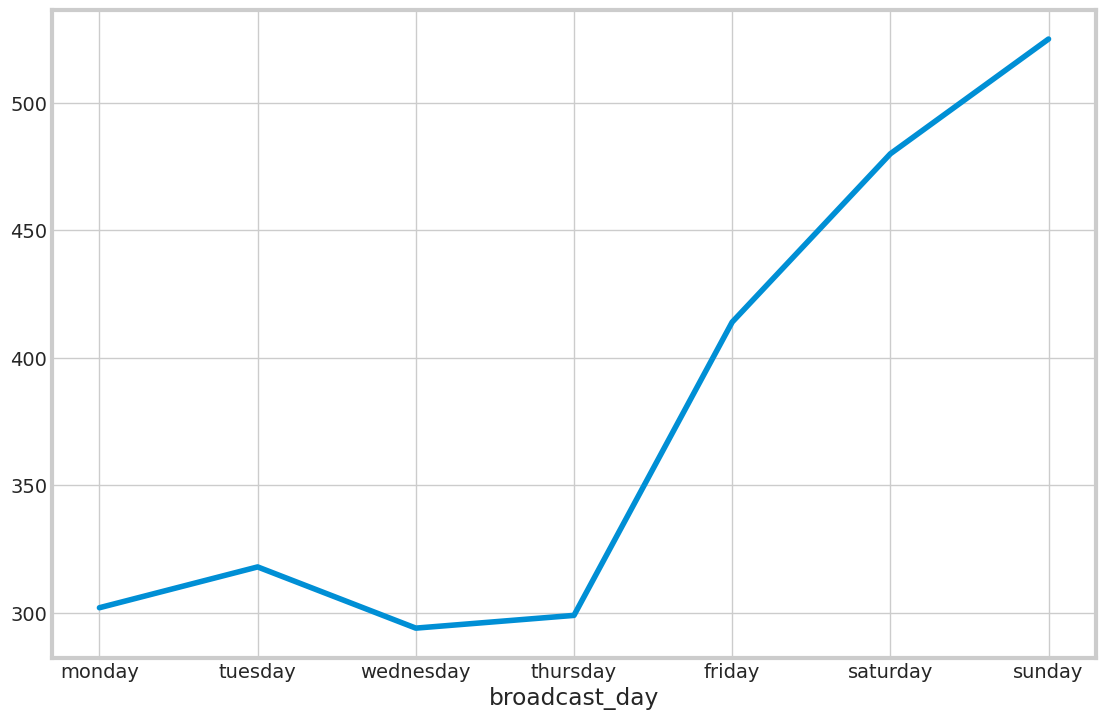

In [16]:
plt.figure(figsize=(12,8))
df['broadcast_day'].value_counts().reindex(['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']).plot()

Проверка распределения оценок аниме

<Axes: xlabel='score', ylabel='Count'>

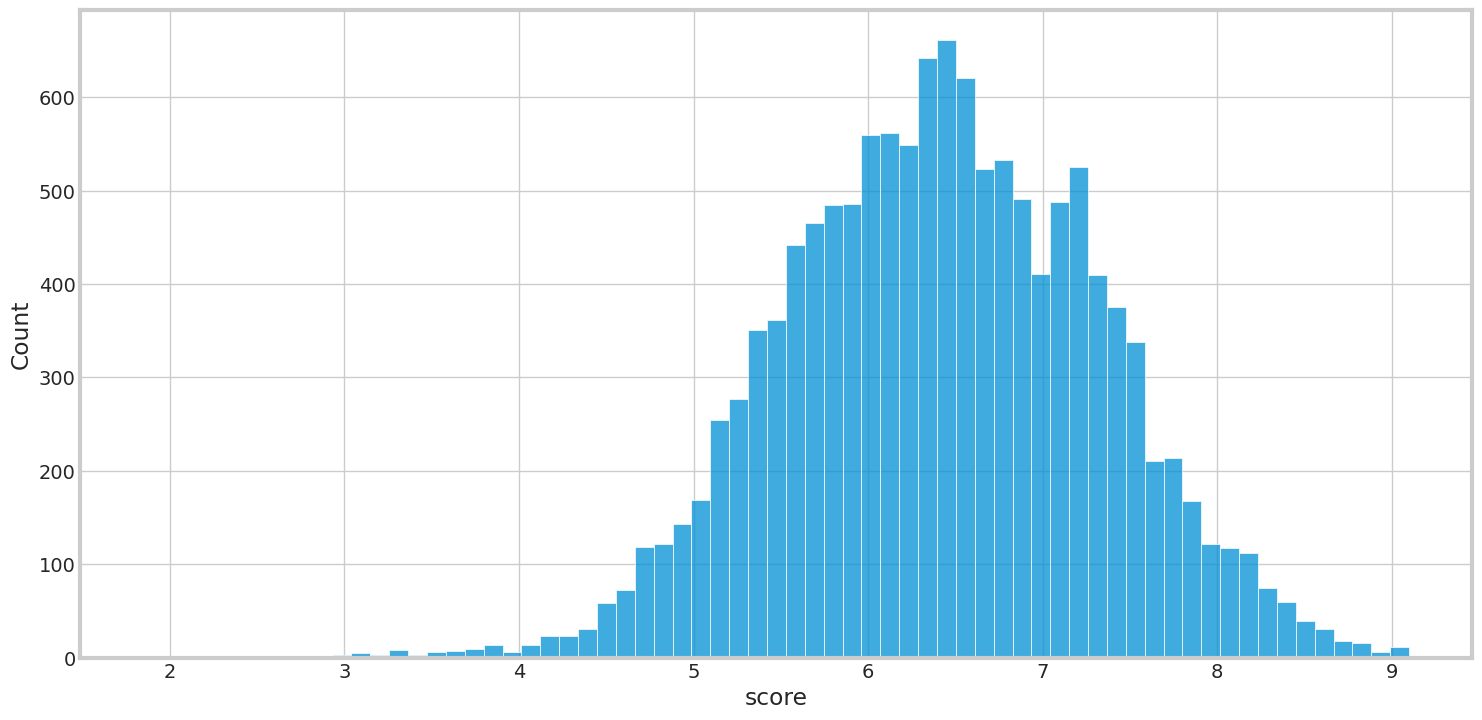

In [18]:
plt.figure(figsize=(16, 8))

sns.histplot(df, x='score')

### Обобщение датасета

Создание обобщенного датасета

In [19]:
# новый датасет для проверки корелляции
grouped_df = df

garbage_columns = [1, 4, 7, 8, 12, 13, 16, 17, 18] + list(range(21,39))

grouped_df = grouped_df.drop(df.columns[garbage_columns], axis=1)

# выводим получившуюся структуру
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 10844 to 19496
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      20000 non-null  int64  
 1   type          19949 non-null  object 
 2   score         12855 non-null  float64
 3   status        20000 non-null  object 
 4   episodes      19565 non-null  float64
 5   source        17151 non-null  object 
 6   members       20000 non-null  int64  
 7   favorites     20000 non-null  int64  
 8   rating        19526 non-null  object 
 9   sfw           20000 non-null  bool   
 10  start_year    16261 non-null  float64
 11  start_season  16261 non-null  object 
dtypes: bool(1), float64(3), int64(3), object(5)
memory usage: 1.9+ MB


Преобразование категориальных признаков в числовые

In [20]:
grouped_df = grouped_df.dropna()

labelencoder = LabelEncoder()

for column in grouped_df.select_dtypes(include=['object']):
    grouped_df[column] = labelencoder.fit_transform(grouped_df[column])

<ipython-input-20-0d78aa1fbd79>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-0d78aa1fbd79>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-0d78aa1fbd79>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-0d78aa1

### Проверка на наличие незначащих признаков

Проверка корреляции признаков

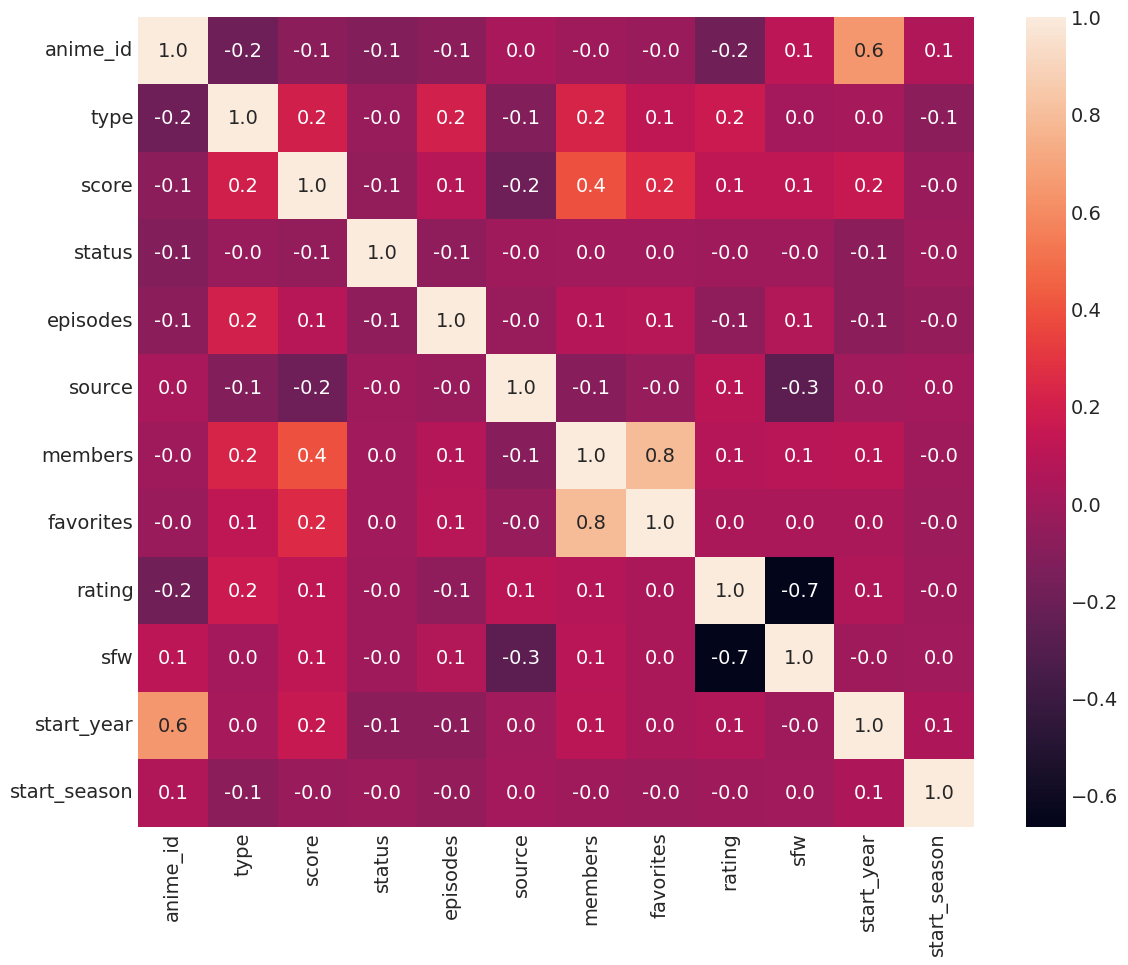

In [21]:
# размер графика
plt.figure(figsize=(12, 10))

# таблица корреляции
sns.heatmap(grouped_df.corr(), annot=True, fmt=".1f");

## Подготовка данных

### Заполнение отсутствующих значений

Проверка на наличие пропусков

In [22]:
# отдельно считаем количество пустых записей в столбцах
skips_num = grouped_df.isna().sum()

print(f"Пропуски по столбцам:\n{skips_num}\n")

# выводим сумму по столбцам
print(f"Всего пропусков: {skips_num.sum()}")


Пропуски по столбцам:
anime_id        0
type            0
score           0
status          0
episodes        0
source          0
members         0
favorites       0
rating          0
sfw             0
start_year      0
start_season    0
dtype: int64

Всего пропусков: 0


### Выбор обучающего и тестового наборов

Разделение данных на те, по которым предсказываем, и на те, которые предсказываем

In [24]:
# выбираем целевой признак
y_df = grouped_df.sfw
# выбираем остальные признаки
X_df = grouped_df.drop(['sfw'], axis=1)


# выводим на всякий случай
X_df.head()

,anime_id,type,score,status,episodes,source,members,favorites,rating,start_year,start_season
10844,51045,1,6.45,1,1.0,9,375,4,2,2022.0,3
7390,38425,3,6.32,1,3.0,5,14318,21,4,2019.0,3
10288,52216,2,6.41,1,1.0,3,756,7,2,2022.0,3
9244,50964,1,6.56,1,1.0,9,835,3,2,2021.0,0
14891,36135,5,5.55,1,25.0,9,1866,0,2,2017.0,0


Выделяем обучающую и тестовую выборки

In [25]:
# разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size = 0.8, random_state=SEED)

### Масштабирование признаков

Выбираем тип масштабирования

In [26]:
# выбираем тип scaler'а
scaler = StandardScaler()

# скалируем
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# проверяем
X_train

array([[-1.22047247,  0.59254227, -0.34855723, ..., -0.04058646,
        -0.52970743, -0.38590251],
       [-1.03069387,  1.17074884,  0.58456608, ...,  0.65545541,
        -3.03396263, -0.38590251],
       [-1.08792239,  0.0143357 , -0.49470907, ..., -0.04058646,
        -1.5162322 , -1.27437573],
       ...,
       [ 0.9057738 , -1.14207744,  1.03426406, ..., -1.43267021,
         0.60859039, -1.27437573],
       [ 0.50023974,  0.0143357 ,  0.71947547, ...,  0.65545541,
         0.53270387, -0.38590251],
       [-1.25047632,  0.0143357 , -0.70831561, ...,  1.35149729,
        -1.36445916,  0.50257071]])

# **ЛР1**

## Описание

Задание 1. Найти набор данных (датасет) для классификации удовлетворяющий следующим условиям: более 10 000 строк, более 20 столбцов, разные типы в столбцах, обязательно наличие целевого признака (таргета).
<br>
Задание 2 . Провести классификацию найденного датасета, методом к- ближайших соседей. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.


## Решение

### Выбор датасета

На основании приведенных в описании 1 лаборатоной работы критериев, был выбран датасет по аниме. Целью работы является выявление видеоматериала, безопасного для просмотра в школе или на работе на основании заранее заданных параметров. Целевой показатель при этом может принимать 2 значения: Аниме безопасно для просмотра (True) и небезопасно (False). Ссылка на используемый датасет приведена далее: https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist/data

### Подключение модулей

In [27]:
# стандартный модуль KNN
from sklearn.neighbors import KNeighborsClassifier

### **sklearn.neighbors.KNeighborsClassifier**

---



#### По-умолчанию

Проверка модели с гиперпараметрами по-умолчанию

In [28]:
%%time

# создаем модель
knn = KNeighborsClassifier()

# подаем на вход модели обучающие данные
knn.fit(X_train, y_train)

CPU times: user 9.46 ms, sys: 10 µs, total: 9.47 ms
Wall time: 13.7 ms


KNeighborsClassifier()

Вывод результатов

In [29]:
# предсказываем результат на тестовой выборке
knn_pred = knn.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, knn_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, knn_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.86      0.96      0.91       857
        True       1.00      0.98      0.99      7858

    accuracy                           0.98      8715
   macro avg       0.93      0.97      0.95      8715
weighted avg       0.98      0.98      0.98      8715


Матрица ошибок: 
[[ 819   38]
 [ 128 7730]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [30]:
%%time

# задаем диапазон параметров
# количество соседей
k_range = [3, 5, 7, 9, 11, 13, 15]
# сравним три стандартных алгоритма knn в sklearn
algorithms = ['ball_tree', 'kd_tree', 'brute']
# метрики расстояния в пространстве признаков
metrics = [
    'euclidean',
    'manhattan',
    'minkowski',
    'chebyshev',
    'hamming',
    'canberra',
    'braycurtis'
]

parameters = {
    'n_neighbors': k_range, # число учитываемых соседей
    'algorithm': algorithms, # алгоритмы поиска соседей
    'weights': ['uniform', 'distance'], # веса соседей
    'leaf_size': [10, 20, 30, 40], # размер листа, используемый в BallTree или KDTree
    'metric': metrics, # метрики расстояния
}

# подбираем лучшие параметры
grid_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)

# обучаем модель
grid_knn.fit(X_train, y_train)

CPU times: user 217 ms, sys: 85.2 ms, total: 302 ms
Wall time: 4.71 s


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [10, 20, 30, 40],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev',
                                                   'hamming', 'canberra',
                                                   'braycurtis'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   scoring='f1')

Вывод результата кросс-валидации

In [31]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_knn.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_knn.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_knn_pred = grid_knn.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_knn_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_knn_pred)}\n')

Лучшие параметры:
{'weights': 'distance', 'n_neighbors': 11, 'metric': 'manhattan', 'leaf_size': 10, 'algorithm': 'kd_tree'}

Показатель f1 для лучшей модели составил: 99.64%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.91      0.96      0.94       857
        True       1.00      0.99      0.99      7858

    accuracy                           0.99      8715
   macro avg       0.95      0.98      0.96      8715
weighted avg       0.99      0.99      0.99      8715


Матрица ошибок: 
[[ 826   31]
 [  82 7776]]



# **ЛР2**

## Описание

Задание 1 . Провести классификацию найденного датасета, методом машины опорных векторов. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Метод машины опорных векторов

In [32]:
# общий модуль для бинарной и многоклассовой классификации
from sklearn.svm import SVC

# специализированный модуль для классификации с линейным ядром
from sklearn.svm import LinearSVC

# модуль для обучения регуляризованных линейных моделей по стохастическому
# градиентному спуску. По-умолчанию обучает линейный SVM
from sklearn.linear_model import SGDClassifier

### **sklearn.linear_model.SGDClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [33]:
%%time

# создаем модель
svm_sgdc = SGDClassifier()

# подаем на вход модели обучающие данные
svm_sgdc.fit(X_train, y_train)

CPU times: user 7.47 ms, sys: 0 ns, total: 7.47 ms
Wall time: 7.65 ms


SGDClassifier()

Вывод результата

In [34]:
# предсказываем результат на тестовой выборке
svm_sgdc_pred = svm_sgdc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, svm_sgdc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, svm_sgdc_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       857
        True       1.00      1.00      1.00      7858

    accuracy                           0.99      8715
   macro avg       0.99      0.98      0.98      8715
weighted avg       0.99      0.99      0.99      8715


Матрица ошибок: 
[[ 823   34]
 [  13 7845]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [35]:
%%time

# задаем параметры
parameters = {
    'penalty': ['none', 'l2', 'l1', 'elasticnet'], # тип регуляризации
    'alpha': [0.001, 0.01, 0.1, 1], # коэффициент регуляризации
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], # стратегия изменения скорости обучения
    'eta0': [0.01, 0.1, 0.2, 0.5], # начальная скорость обучения
    'fit_intercept': [True, False], # следует ли добавлять константный член в линейную модель
    'tol': [1e-3, 1e-4, 1e-5], # пороговое значение для оптимизации
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'], # функция потерь
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], # коэффициент для смешивания L1 и L2 регуляризации
    'average': [True, False] # следует ли усреднять веса классов
}

# подбираем лучшие параметры
grid_svm_sgdc = RandomizedSearchCV(
    SGDClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_svm_sgdc.fit(X_train, y_train)

CPU times: user 152 ms, sys: 5.78 ms, total: 158 ms
Wall time: 884 ms


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 891, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-pack

RandomizedSearchCV(estimator=SGDClassifier(), n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1],
                                        'average': [True, False],
                                        'eta0': [0.01, 0.1, 0.2, 0.5],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_huber',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['none', 'l2', 'l1',
                                                    'elasticnet'],
                                        'tol': [0.001, 0.0001, 1e-05]},
                   scoring='f1')

Вывод результата кросс-валидации

In [36]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_sgdc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_sgdc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_sgdc_pred = grid_svm_sgdc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_sgdc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_sgdc_pred)}\n')

Лучшие параметры:
{'tol': 1e-05, 'penalty': 'l2', 'loss': 'modified_huber', 'learning_rate': 'optimal', 'l1_ratio': 1.0, 'fit_intercept': True, 'eta0': 0.1, 'average': False, 'alpha': 0.01}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 822   35]
 [   1 7857]]



### **sklearn.svm.SVC**

---

#### По-умолчанию

Создание и обучение модели

In [37]:
%%time

# создаем модель
svm_svc = SVC()

# подаем на вход модели обучающие данные
svm_svc.fit(X_train, y_train)

CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 133 ms


SVC()

Вывод результата

In [38]:
# предсказываем результат на тестовой выборке
svm_svc_pred = svm_svc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, svm_svc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, svm_svc_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 822   35]
 [   1 7857]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [39]:
%%time

# задаем гиперпараметры
parameters = {
    'C': [0.1, 1], # коэффициент регуляризации
    'kernel': ['poly', 'rbf', 'sigmoid'], # тип ядра
    'degree': [3, 4] # степень для 'poly' ядра
    #'gamma': ['scale', 'auto'], # коэффициент ядра для 'rbf', 'poly' и 'sigmoid'
    #'coef0': [0.0, 0.5, 1.0], # смещение для 'poly' и 'sigmoid'
    #'tol': [1e-3, 1e-4], # пороговое значение для оптимизации
    #'class_weight': [None, 'balanced'], # веса классов
}

# подбираем лучшие параметры
grid_svm_svc = RandomizedSearchCV(
    SVC(),
    parameters,
    scoring='f1',
    n_jobs = -1
)

# обучаем модель
grid_svm_svc.fit(X_train, y_train)

CPU times: user 140 ms, sys: 8.54 ms, total: 149 ms
Wall time: 1.94 s


RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1], 'degree': [3, 4],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   scoring='f1')

Вывод результата кросс-валидации

In [40]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_svc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_svc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_svc_pred = grid_svm_svc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_svc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_svc_pred)}\n')

Лучшие параметры:
{'kernel': 'rbf', 'degree': 4, 'C': 1}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 822   35]
 [   1 7857]]



### **sklearn.svm.LinearSVC**

---

#### По-умолчанию

Создание и обучение модели

In [41]:
%%time

# создаем модель
svm_lsvc = LinearSVC()

# подаем на вход модели обучающие данные
svm_lsvc.fit(X_train, y_train)

CPU times: user 14.4 ms, sys: 1.02 ms, total: 15.5 ms
Wall time: 19.6 ms


LinearSVC()

Вывод результата

In [42]:
# предсказываем результат на тестовой выборке
svm_lsvc_pred = svm_lsvc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, svm_lsvc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, svm_lsvc_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 826   31]
 [   2 7856]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [43]:
%%time

# задаем диапазон параметров
parameters = {
    #'penalty': ['l1', 'l2'], # тип регуляризации, l2 по-умолчанию
                             # l1 приводит к разреженным _coef
    'loss': ['hinge', 'squared_hinge'], # функция потерь
                                        # проверяем обе
    #'dual': [True, False], # следует ли использовать двойственную форму задачи, True по-умолчанию
                            # поскольку n_samples > n_features, берем двойственную
    'tol': [1e-4, 1e-3], # пороговое значение для оптимизации, 1e-3 по-умолчанию
    'C': [10], # коэффициент регуляризации
               # проверяем методом научного тыка
    #'fit_intercept': [True, False], # следует ли добавлять константный член (центрирование)
                                     # True по-умолчанию
    'intercept_scaling': [1, 10, 100], # масштабирование константного члена
    #'class_weight': [None, 'balanced'] # веса классов
}

# подбираем лучшие параметры
grid_svm_lsvc = RandomizedSearchCV(LinearSVC(), parameters, scoring='f1', n_jobs=-1)
# обучаем модель
grid_svm_lsvc.fit(X_train, y_train)

CPU times: user 114 ms, sys: 7.41 ms, total: 121 ms
Wall time: 910 ms


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



RandomizedSearchCV(estimator=LinearSVC(), n_jobs=-1,
                   param_distributions={'C': [10],
                                        'intercept_scaling': [1, 10, 100],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'tol': [0.0001, 0.001]},
                   scoring='f1')

Вывод результата кросс-валидации

In [44]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_lsvc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_lsvc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_lsvc_pred = grid_svm_lsvc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_lsvc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_lsvc_pred)}\n')

Лучшие параметры:
{'tol': 0.001, 'loss': 'hinge', 'intercept_scaling': 10, 'C': 10}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 826   31]
 [   1 7857]]



# **ЛР3**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами линеной и логистической регрессий . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Методы линейной регрессии

In [45]:
# стандартная модель
from sklearn.linear_model import LinearRegression

# для комбинированных L1- и L2-регуляризаций
from sklearn.linear_model import ElasticNet

# для L1-регуляризации
from sklearn.linear_model import Lasso

# для L2-регуляризации
from sklearn.linear_model import Ridge

# для стохастического градиентного спуска
from sklearn.linear_model import SGDRegressor

Методы логистической регрессии

In [46]:
# стандартная модель, поддерживающая бинарную, One-vs-Rest и мультиномиальную
# логистическую регрессию с опциональной регуляризацией L1, L2 или Elastic-Net
from sklearn.linear_model import LogisticRegression

### **sklearn.linear_model.LinearRegression**

---



#### Проверка обычной регрессии

Создание и обучение модели

In [47]:
%%time

# создаем модель
regression_linear = LinearRegression()

# подаем на вход модели обучающие данные
regression_linear.fit(X_train, y_train)

CPU times: user 5.32 ms, sys: 5.09 ms, total: 10.4 ms
Wall time: 39.1 ms


LinearRegression()

Вывод результата

In [48]:
# предсказываем результат на тестовой выборке
regression_linear_pred = regression_linear.predict(X_test)

# заводим переменные
mae = mean_absolute_error(y_test, regression_linear_pred)
mse = mean_squared_error(y_test, regression_linear_pred)

# оцениваем модель
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {np.sqrt(mse):.5f}')

MAE: 0.16357
MSE: 0.04375
RMSE: 0.20917


### **sklearn.linear_model.LogisticRegression**

---



#### По-умолчанию

Создание и обучение модели

In [49]:
%%time

# создаем модель
regression_logistic = LogisticRegression()

# подаем на вход модели обучающие данные
regression_logistic.fit(X_train, y_train)

CPU times: user 21.8 ms, sys: 24.3 ms, total: 46.1 ms
Wall time: 33.6 ms


LogisticRegression()

Вывод результата

In [50]:
# предсказываем результат на тестовой выборке
regression_logistic_pred = regression_logistic.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, regression_logistic_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, regression_logistic_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 825   32]
 [   1 7857]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [51]:
%%time

# задаем диапазон параметров
parameters = {
    'penalty': ['l1', 'l2'], # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10], # инверсное значение коэффициента регуляризации
    #'fit_intercept': [True, False], # следует ли добавлять константный член в линейную модель
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # алгоритм оптимизации
    #'tol': [1e-4, 1e-3], # пороговое значение для оптимизации
    #'class_weight': [None, 'balanced'] # веса классов
}

# подбираем лучшие параметры
grid_regression_logistic = RandomizedSearchCV(
    LogisticRegression(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_regression_logistic.fit(X_train, y_train)

CPU times: user 127 ms, sys: 7.97 ms, total: 135 ms
Wall time: 1.46 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='f1')

Вывод результата кросс-валидации

In [52]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_regression_logistic.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_regression_logistic.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_regression_logistic_pred = grid_regression_logistic.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_regression_logistic_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_regression_logistic_pred)}\n')

Лучшие параметры:
{'solver': 'liblinear', 'penalty': 'l2', 'C': 10}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 825   32]
 [   1 7857]]



# **ЛР4**


## Описание

Задание 1 . Провести классификацию найденного датасета, методами наивного Байеса  . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [53]:
# гауссовский наивный байесовский алгоритм для классификации
# когда вероятность появления признаков Гауссова
from sklearn.naive_bayes import GaussianNB

# для классификации текстовых документов, где признаки представляют собой частоты слов
from sklearn.naive_bayes import MultinomialNB

# для работы с бинарными признаками
from sklearn.naive_bayes import ComplementNB

# обобщение наивного байесовского классификатора, учитывающее
# дополнительные сведения о распределении признаков
from sklearn.naive_bayes import BernoulliNB

# для работы с категориальными признаками
from sklearn.naive_bayes import CategoricalNB

### **sklearn.naive_bayes.GaussianNB**

---



#### Обычная байесовская модель

Создание и обучение модели

In [54]:
%%time

# вероятности классов - единственный параметр GaussianNB
# priors по-умолчанию None (вычисляются на основе входных данных)
"""parameters = {'priors': [None]}"""

# создаем модель
nb_gaussian = GaussianNB()

# подаем на вход модели обучающие данные
nb_gaussian.fit(X_train, y_train)

CPU times: user 3.12 ms, sys: 1 µs, total: 3.12 ms
Wall time: 3.15 ms


GaussianNB()

Вывод результата

In [55]:
# предсказываем результат на тестовой выборке
nb_gaussian_pred = nb_gaussian.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, nb_gaussian_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, nb_gaussian_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.76      0.96      0.85       857
        True       1.00      0.97      0.98      7858

    accuracy                           0.97      8715
   macro avg       0.88      0.96      0.92      8715
weighted avg       0.97      0.97      0.97      8715


Матрица ошибок: 
[[ 825   32]
 [ 257 7601]]



### **sklearn.naive_bayes.BernoulliNB**

---



#### По-умолчанию

Создание и обучение модели

In [56]:
%%time

# создаем модель
nb_bernoulli = BernoulliNB()

# подаем на вход модели обучающие данные
nb_bernoulli.fit(X_train, y_train)

CPU times: user 5.99 ms, sys: 0 ns, total: 5.99 ms
Wall time: 5.97 ms


BernoulliNB()

Вывод результата

In [57]:
# предсказываем результат на тестовой выборке
nb_bernoulli_pred = nb_bernoulli.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, nb_bernoulli_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, nb_bernoulli_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.63      0.87      0.73       857
        True       0.99      0.94      0.96      7858

    accuracy                           0.94      8715
   macro avg       0.81      0.91      0.85      8715
weighted avg       0.95      0.94      0.94      8715


Матрица ошибок: 
[[ 745  112]
 [ 444 7414]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [58]:
%%time

# задаем диапазон параметров
parameters = {
    'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0], # аддитивное (Лапласа-Лидстоуна) сглаживание
    'force_alpha': [True, False], # применять ли alpha, или ставить в 1e-10
    'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # пороговое значение
                                                                               # для бинаризации признаков
    'fit_prior': [True, False], # следует ли использовать приоритеты классов, вычисленные из данных
    #'class_prior': [None] #  вероятности классов, используемые в качестве приоритетов
}


# подбираем лучшие параметры
grid_nb_bernoulli = GridSearchCV(
    BernoulliNB(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_nb_bernoulli.fit(X_train, y_train)

CPU times: user 826 ms, sys: 53.4 ms, total: 879 ms
Wall time: 9.11 s


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.



GridSearchCV(estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                      0.7, 0.8, 0.9, 1.0],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             scoring='f1')

Вывод результата кросс-валидации

In [59]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_nb_bernoulli.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_nb_bernoulli.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_nb_bernoulli_pred = grid_nb_bernoulli.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_nb_bernoulli_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_nb_bernoulli_pred)}\n')

Лучшие параметры:
{'alpha': 0, 'binarize': 0.8, 'fit_prior': True, 'force_alpha': False}

Показатель f1 для лучшей модели составил: 97.87%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.69      0.90      0.78       857
        True       0.99      0.96      0.97      7858

    accuracy                           0.95      8715
   macro avg       0.84      0.93      0.88      8715
weighted avg       0.96      0.95      0.95      8715


Матрица ошибок: 
[[ 769   88]
 [ 340 7518]]



# **ЛР5**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами решающего дерева и случайного леса . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [60]:
# базовый классификатор, используемый внутри RandomForestClassifier и BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# классификатор на ансамбле случайных деревьев
from sklearn.ensemble import RandomForestClassifier

# классификатор использует метод Bagging
from sklearn.ensemble import BaggingClassifier

# классификатор использующий метод градиентного бустинга
from sklearn.ensemble import GradientBoostingClassifier

### **sklearn.tree.DecisionTreeClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [61]:
%%time

# создаем модель
ensemble_tree = DecisionTreeClassifier()

# подаем на вход модели обучающие данные
ensemble_tree.fit(X_train, y_train)

CPU times: user 7.85 ms, sys: 0 ns, total: 7.85 ms
Wall time: 7.75 ms


DecisionTreeClassifier()

Вывод результата

In [62]:
# предсказываем результат на тестовой выборке
ensemble_tree_pred = ensemble_tree.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_tree_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_tree_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.95      0.97      0.96       857
        True       1.00      0.99      1.00      7858

    accuracy                           0.99      8715
   macro avg       0.97      0.98      0.98      8715
weighted avg       0.99      0.99      0.99      8715


Матрица ошибок: 
[[ 830   27]
 [  45 7813]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [63]:
%%time

# задаем диапазон параметров
parameters = {
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'splitter': ['best', 'random'], # стратегия выбора признака для разделения
    'max_depth': [None, 10, 20, 30, 40, 50], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10, 20], # минимальное количество образцов для разделения узла
    #'min_samples_leaf': [1, 2, 5, 10], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальная доля веса образцов в листе
    'max_features': [None, 'auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    'class_weight': [None, 'balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # параметр для контроля сжатия дерева
}

# подбираем лучшие параметры
grid_ensemble_tree = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_tree.fit(X_train, y_train)

CPU times: user 4.24 s, sys: 179 ms, total: 4.42 s
Wall time: 37.3 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


2880 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2880 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='f1')

Вывод результата кросс-валидации

In [64]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_tree.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_tree.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_tree_pred = grid_ensemble_tree.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_tree_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_tree_pred)}\n')

Лучшие параметры:
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'splitter': 'random'}

Показатель f1 для лучшей модели составил: 99.87%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       857
        True       1.00      1.00      1.00      7858

    accuracy                           0.99      8715
   macro avg       0.98      0.98      0.98      8715
weighted avg       0.99      0.99      0.99      8715


Матрица ошибок: 
[[ 829   28]
 [  28 7830]]



### **sklearn.ensemble.RandomForestClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [65]:
%%time

# создаем модель
ensemble_randforest = RandomForestClassifier()

# подаем на вход модели обучающие данные
ensemble_randforest.fit(X_train, y_train)

CPU times: user 296 ms, sys: 3.21 ms, total: 299 ms
Wall time: 298 ms


RandomForestClassifier()

Вывод результата

In [66]:
# предсказываем результат на тестовой выборке
ensemble_randforest_pred = ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_randforest_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 826   31]
 [   1 7857]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [67]:
%%time

# задаем диапазон параметров
parameters = {
    'n_estimators': [100, 200], # количество деревьев в лесу
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'max_depth': [None, 50, 100], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10], # минимальное количество образцов для разделения узла
    #'min_samples_leaf': [1, 2, 4], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1], # минимальная доля веса образцов в листе
    'max_features': ['auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    #'bootstrap': [True, False], # следует ли использовать bootstrap-выборку при построении деревьев
    'oob_score': [True, False], # следует ли использовать out-of-bag (OOB) оценку для оценки качества модели
    #'class_weight': [None, 'balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # параметр контроля сжатия дерева
    #'max_samples': [None] # максимальное количество образцов для обучения каждого дерева
}

# подбираем лучшие параметры
grid_ensemble_randforest = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    n_jobs = -1
)
# обучаем модель
grid_ensemble_randforest.fit(X_train, y_train)

CPU times: user 841 ms, sys: 59.9 ms, total: 901 ms
Wall time: 28.8 s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200],
                                        'oob_score': [True, False]})

Вывод результата кросс-валидации

In [68]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_randforest.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_randforest.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_randforest_pred = grid_ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_randforest_pred)}\n')

Лучшие параметры:
{'oob_score': True, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'ccp_alpha': 0.0}

Показатель f1 для лучшей модели составил: 99.68%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 827   30]
 [   1 7857]]



### **sklearn.ensemble.BaggingClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [69]:
%%time

# создаем модель
ensemble_bagging = BaggingClassifier()

# подаем на вход модели обучающие данные
ensemble_bagging.fit(X_train, y_train)

CPU times: user 48.6 ms, sys: 2.7 ms, total: 51.3 ms
Wall time: 53.7 ms


BaggingClassifier()

Вывод результата

In [70]:
# предсказываем результат на тестовой выборке
ensemble_bagging_pred = ensemble_bagging.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_bagging_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_bagging_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       0.99      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 829   28]
 [  10 7848]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [71]:
%%time

# задаем диапазон параметров
parameters = {
    # 'base_estimator': [None, 'DecisionTreeClassifier', 'RandomForestClassifier'], # базовый оценщик
    'n_estimators': [10, 50, 100, 200], # количество базовых оценщиков в ансамбле
    'max_samples': [0.5, 0.75, 1.0], # доля общего количества образцов,
                                     # используемая при обучении каждого базового оценщика
    'max_features': [0.5, 0.75, 1.0], # доля общего количества признаков,
                                      # используемая при обучении каждого базового оценщика
    #'bootstrap': [True, False], #  следует ли использовать bootstrap-выборку при построении базовых оценщиков
    #'bootstrap_features': [True, False], # следует ли использовать bootstrap-выборку признаков
                                         # при обучении каждого базового оценщика
    'oob_score': [True, False] # следует ли использовать out-of-bag (OOB) оценку для оценки качества модели
}

# подбираем лучшие параметры
grid_ensemble_randforest = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_randforest.fit(X_train, y_train)

CPU times: user 246 ms, sys: 27.2 ms, total: 273 ms
Wall time: 7.71 s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_features': [0.5, 0.75, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'n_estimators': [10, 50, 100, 200],
                                        'oob_score': [True, False]},
                   scoring='f1')

Вывод результата кросс-валидации

In [72]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_randforest.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_randforest.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_randforest_pred = grid_ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_randforest_pred)}\n')

Лучшие параметры:
{'oob_score': True, 'n_estimators': 10, 'max_samples': 0.75, 'max_features': 1.0}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 828   29]
 [   5 7853]]



### **sklearn.ensemble.GradientBoostingClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [73]:
%%time

# создаем модель
ensemble_gradboost = GradientBoostingClassifier()

# подаем на вход модели обучающие данные
ensemble_gradboost.fit(X_train, y_train)

CPU times: user 497 ms, sys: 0 ns, total: 497 ms
Wall time: 501 ms


GradientBoostingClassifier()

Вывод результата

In [74]:
# предсказываем результат на тестовой выборке
ensemble_gradboost_pred = ensemble_gradboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_gradboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_gradboost_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 828   29]
 [   2 7856]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [75]:
%%time

# задаем диапазон параметров
parameters = {
    "loss": ["deviance", "exponential", "log_loss"], # функция потерь
    "learning_rate": [0.01, 0.05, 0.1, 0.2], # скорость обучения
    #"min_samples_split": np.linspace(0.1, 0.5, 12), # минимальное количество образцов для разделения узла
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12), # минимальное количество образцов для листа
    #"max_depth": [3, 5, 8], # максимальная глубина дерева
    "max_features": ["log2", "sqrt"], # количество признаков при поиске лучшего разделения
    "criterion": ["friedman_mse", "mae"], # функция для измерения качества разделения
    "subsample": [0.5, 0.95, 1.0], # доля от общего количества образцов,
                                                          # используемая при обучения каждого дерева
    "n_estimators": [100, 200] # количество деревьев в ансамбле
}
# подбираем лучшие параметры
grid_ensemble_gradboost = RandomizedSearchCV(
    GradientBoostingClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_gradboost.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

CPU times: user 335 ms, sys: 15.7 ms, total: 350 ms
Wall time: 3.49 s


RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse', 'mae'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'loss': ['deviance', 'exponential',
                                                 'log_loss'],
                                        'max_features': ['log2', 'sqrt'],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.5, 0.95, 1.0]},
                   scoring='f1')

Вывод результата кросс-валидации

In [76]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_gradboost.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_gradboost.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_gradboost_pred = grid_ensemble_gradboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_gradboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_gradboost_pred)}\n')

Лучшие параметры:
{'subsample': 1.0, 'n_estimators': 100, 'max_features': 'sqrt', 'loss': 'log_loss', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 829   28]
 [   1 7857]]



# **ЛР6**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами CatBoost. В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Подключение модуля классификатора

In [77]:
# основной модуль классификатора
from catboost import CatBoostClassifier

### **catboost.CatBoostClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [78]:
%%time

# создаем модель
catboost = CatBoostClassifier()

# подаем на вход модели обучающие данные
catboost.fit(X_train, y_train)

Learning rate set to 0.014364
0:	learn: 0.6541650	total: 50.6ms	remaining: 50.5s
1:	learn: 0.6133304	total: 53.5ms	remaining: 26.7s
2:	learn: 0.5703082	total: 55.3ms	remaining: 18.4s
3:	learn: 0.5352844	total: 58.1ms	remaining: 14.5s
4:	learn: 0.5026428	total: 61.2ms	remaining: 12.2s
5:	learn: 0.4694115	total: 64.9ms	remaining: 10.8s
6:	learn: 0.4425303	total: 68.3ms	remaining: 9.69s
7:	learn: 0.4196084	total: 72.7ms	remaining: 9.02s
8:	learn: 0.3974272	total: 76.1ms	remaining: 8.38s
9:	learn: 0.3709421	total: 79.2ms	remaining: 7.84s
10:	learn: 0.3512902	total: 86.1ms	remaining: 7.74s
11:	learn: 0.3331620	total: 89.7ms	remaining: 7.39s
12:	learn: 0.3150700	total: 92.4ms	remaining: 7.02s
13:	learn: 0.2985018	total: 95.4ms	remaining: 6.72s
14:	learn: 0.2836318	total: 99.2ms	remaining: 6.52s
15:	learn: 0.2692433	total: 103ms	remaining: 6.31s
16:	learn: 0.2535089	total: 106ms	remaining: 6.15s
17:	learn: 0.2394479	total: 109ms	remaining: 5.95s
18:	learn: 0.2268453	total: 112ms	remaining: 5.

Вывод результата

In [79]:
# предсказываем результат на тестовой выборке
catboost_pred = catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, catboost_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 827   30]
 [   3 7855]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [80]:
%%time

# задаем диапазон параметров
# задаем параметры
parameters = {
    'depth': [5, 10], # максимальная глубина дерева
    'learning_rate': [0.01, 0.1], # скорость обучения
    'iterations': [10, 100], # количество итераций
    'l2_leaf_reg': [1, 10], # коэффициент L2 регуляризации листьев
    'border_count': [1, 255], # количество границ для числовых признаков
    'loss_function': ['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll'], # функция потерь
    'random_strength': [0, 1], # сила случайности в выборе признаков на каждом уровне
    'bagging_temperature': [0, 1], # температура для баггинга
    'od_type': ['IncToDec', 'Iter', 'None'], # тип оптимизации
    'od_wait': [10, 100] # количество итераций между проверками оптимизации
}

# подбираем лучшие параметры
grid_catboost = RandomizedSearchCV(
    CatBoostClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_catboost.fit(X_train, y_train)

0:	learn: 0.6093917	total: 2.83ms	remaining: 280ms
1:	learn: 0.5358041	total: 5.4ms	remaining: 265ms
2:	learn: 0.4739976	total: 7.53ms	remaining: 244ms
3:	learn: 0.4269254	total: 11.4ms	remaining: 273ms
4:	learn: 0.3808668	total: 13.6ms	remaining: 258ms
5:	learn: 0.3456291	total: 17.6ms	remaining: 276ms
6:	learn: 0.3142621	total: 21.1ms	remaining: 280ms
7:	learn: 0.2884533	total: 28.1ms	remaining: 324ms
8:	learn: 0.2636896	total: 35.3ms	remaining: 357ms
9:	learn: 0.2388651	total: 41.1ms	remaining: 370ms
10:	learn: 0.2203179	total: 52.6ms	remaining: 426ms
11:	learn: 0.2044386	total: 87ms	remaining: 638ms
12:	learn: 0.1871257	total: 90.7ms	remaining: 607ms
13:	learn: 0.1733993	total: 95.9ms	remaining: 589ms
14:	learn: 0.1586462	total: 98.6ms	remaining: 559ms
15:	learn: 0.1493274	total: 111ms	remaining: 580ms
16:	learn: 0.1391175	total: 120ms	remaining: 584ms
17:	learn: 0.1313950	total: 125ms	remaining: 571ms
18:	learn: 0.1241509	total: 131ms	remaining: 557ms
19:	learn: 0.1157328	total: 1

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7905199af760>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1],
                                        'border_count': [1, 255],
                                        'depth': [5, 10],
                                        'iterations': [10, 100],
                                        'l2_leaf_reg': [1, 10],
                                        'learning_rate': [0.01, 0.1],
                                        'loss_function': ['Logloss',
                                                          'CrossEntropy',
                                                          'MultiClass',
                                                          'MultiClassOneVsAll'],
                                        'od_type': ['IncToDec', 'Iter', 'None'],
                                        'od_wait': [10, 100],
                                        'random_strength': [0, 1]},
                   scoring='f1')

Вывод результата кросс-валидации

In [81]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_catboost.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_catboost.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_catboost_pred = grid_catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_catboost_pred)}\n')

Лучшие параметры:
{'random_strength': 0, 'od_wait': 10, 'od_type': 'Iter', 'loss_function': 'MultiClassOneVsAll', 'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 100, 'depth': 10, 'border_count': 255, 'bagging_temperature': 1}

Показатель f1 для лучшей модели составил: 99.82%

Сравнение метрик: 
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       857
        True       1.00      1.00      1.00      7858

    accuracy                           1.00      8715
   macro avg       1.00      0.98      0.99      8715
weighted avg       1.00      1.00      1.00      8715


Матрица ошибок: 
[[ 826   31]
 [   1 7857]]

